In [9]:
%pip uninstall matplotlib
%pip install yfinance arch statsmodels pandas numpy matplotlib seaborn scikit-learn

^C
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\azizb\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [10]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from arch import arch_model
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

tickers = ["^GSPC", "^N225", "^FTSE"]  # S&P 500, Nikkei 225, FTSE 100
data = yf.download(tickers, start="2010-01-01", end="2024-01-01")["Close"]
data.columns = ["SP500", "Nikkei", "FTSE"]

data.head()

[*********************100%***********************]  3 of 3 completed


,SP500,Nikkei,FTSE
Date,,,
2010-01-04,5500.299805,1132.989990,10654.790039
2010-01-05,5522.500000,1136.520020,10681.830078
2010-01-06,5530.000000,1137.140015,10731.450195
2010-01-07,5526.700195,1141.689941,10681.660156
2010-01-08,5534.200195,1144.979980,10798.320312


In [5]:
monthly_data = data.resample("M").mean()
monthly_data.head()

C:\Users\azizb\AppData\Local\Temp\ipykernel_25672\4238368151.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = data.resample("M").mean()


,SP500,Nikkei,FTSE
Date,,,
2010-01-31,5411.645020,1123.581582,10661.623201
2010-02-28,5231.925000,1089.159989,10175.129009
2010-03-31,5621.030465,1152.048690,10671.490456
2010-04-30,5720.744995,1197.316185,11139.770043
2010-05-31,5222.873715,1125.062006,10103.978299


In [6]:
returns = pd.DataFrame()
returns["SP500_Return"] = np.log(data["SP500"] / data["SP500"].shift(1))
returns["Nikkei_Return"] = np.log(data["Nikkei"] / data["Nikkei"].shift(1))
returns["FTSE_Return"] = np.log(data["FTSE"] / data["FTSE"].shift(1))

returns = returns.dropna()

In [11]:
def adf_test(series, title):
    result = adfuller(series)
    print(f'ADF Test for {title}:')
    print(f'Test Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')

adf_test(returns["SP500_Return"], "S&P 500 Returns")
adf_test(returns["Nikkei_Return"], "Nikkei Returns")
adf_test(returns["FTSE_Return"], "FTSE Returns")

ADF Test for S&P 500 Returns:
Test Statistic: -21.908714132213888
p-value: 0.0
Critical Values:
   1%: -3.432566387909864
   5%: -2.862519254448958
   10%: -2.567291283859137
ADF Test for Nikkei Returns:
Test Statistic: -14.198777180889898
p-value: 1.8030243675720691e-26
Critical Values:
   1%: -3.4325769549719443
   5%: -2.862523921490829
   10%: -2.5672937685495976
ADF Test for FTSE Returns:
Test Statistic: -28.79475668603802
p-value: 0.0
Critical Values:
   1%: -3.432563387143659
   5%: -2.8625179291294662
   10%: -2.5672905782716513


All returns series (S&P 500, Nikkei, FTSE) are stationary  (p-values ≈ 0 < 0.01).  
Suitable for modeling with ARIMA/GARCH/VAR.

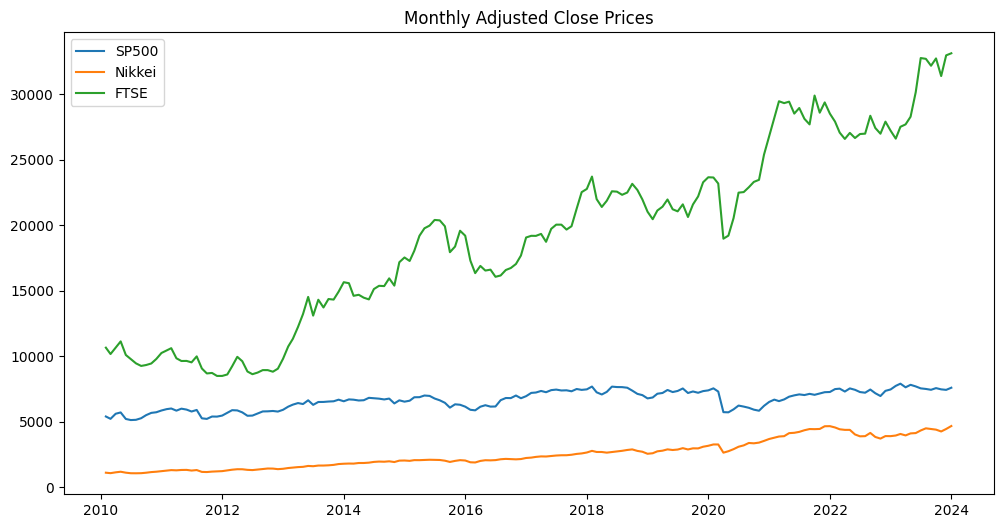

In [12]:
plt.figure(figsize=(12, 6))
for col in monthly_data.columns:
    plt.plot(monthly_data[col], label=col)
plt.title("Monthly Adjusted Close Prices")
plt.legend()
plt.savefig("price_trends.png")
plt.show()

Key Observations :  
FTSE 100  shows the sharpest increase post-2020 (COVID recovery).  
Nikkei 225  grows steadily but remains below pre-2020 levels.  
S&P 500  fluctuates but follows an upward trend.

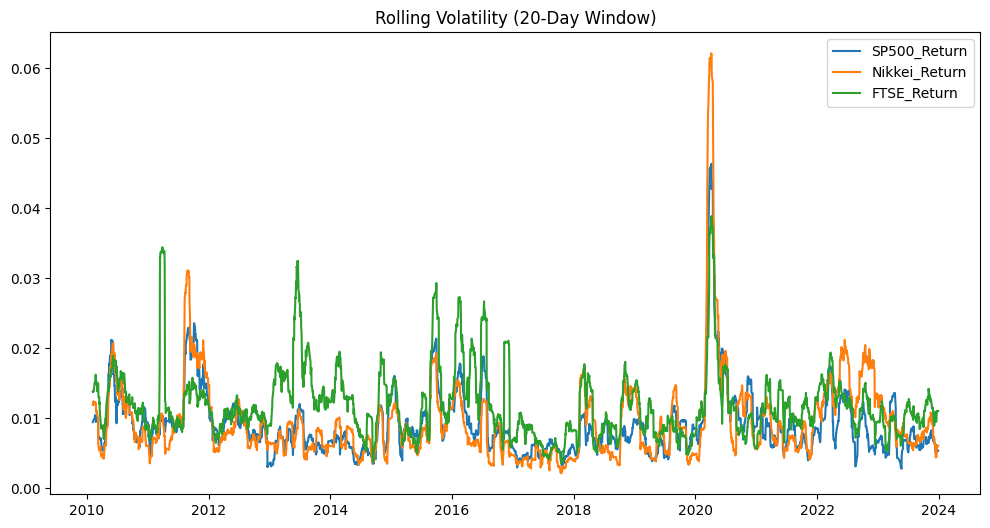

In [13]:
rolling_vol = returns.rolling(window=20).std()

plt.figure(figsize=(12, 6))
for col in rolling_vol.columns:
    plt.plot(rolling_vol[col], label=col)
plt.title("Rolling Volatility (20-Day Window)")
plt.legend()
plt.savefig("volatility_clustering.png")
plt.show()

Major Spike in 2020 :  
    COVID-19 Market Crash  caused extreme volatility across all indices.  
    FTSE 100  had the highest volatility during this period.

In [ ]:
returns_df = returns.copy()
returns_df['weekday'] = returns_df.index.dayofweek
returns_df.head()

,SP500_Return,Nikkei_Return,FTSE_Return,weekday
Date,,,,
2010-01-05,0.004028,0.003111,0.002535,1
2010-01-06,0.001357,0.000545,0.004635,2
2010-01-07,-0.000597,0.003993,-0.004650,3
2010-01-08,0.001356,0.002878,0.010862,4
2010-01-13,-0.004593,0.008291,-0.013335,2


Fit GARCH(1,1) Models to Each Return Series
Estimate conditional volatility with a univariate GARCH(1,1) for each asset return.

In [15]:
from arch import arch_model

garch_results = {}
for col in ['SP500_Return', 'Nikkei_Return', 'FTSE_Return']:
    model = arch_model(returns_df[col], vol='Garch', p=1, q=1, dist='normal')
    res = model.fit(update_freq=5, disp='off')
    garch_results[col] = res
    print(f"### GARCH(1,1) Results for {col}")
    display(res.summary())

### GARCH(1,1) Results for SP500_Return


C:\Users\azizb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001033. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:           SP500_Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                9821.90
Distribution:                  Normal   AIC:                          -19635.8
Method:            Maximum Likelihood   BIC:                          -19611.8
                                        No. Observations:                 2961
Date:                Mon, May 19 2025   Df Residuals:                     2960
Time:                        07:42:36   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         3.6402e-04  1.007e-05     36.160 2.596e-286 [3.443e-04,3.838e-04]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      1.0325e-05  2.030e-11  5.085e+05      0.000 [1.033e-05,1.033e-05]
alpha[1]       0.2000  2.280e-02      8.773  1.740e-18     [  0.155,  0.245]
beta[1]        0.7000  1.710e-02     40.936      0.000     [  0.666,  0.734]
============================================================================

Covariance estimator: robust
"""

### GARCH(1,1) Results for Nikkei_Return


C:\Users\azizb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001262. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:          Nikkei_Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                9767.06
Distribution:                  Normal   AIC:                          -19526.1
Method:            Maximum Likelihood   BIC:                          -19502.1
                                        No. Observations:                 2961
Date:                Mon, May 19 2025   Df Residuals:                     2960
Time:                        07:42:36   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         8.9232e-04  2.148e-06    415.398      0.000 [8.881e-04,8.965e-04]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      2.5236e-06  9.199e-12  2.743e+05      0.000 [2.524e-06,2.524e-06]
alpha[1]       0.2000  2.804e-02      7.132  9.898e-13     [  0.145,  0.255]
beta[1]        0.7800  2.336e-02     33.385 2.242e-244     [  0.734,  0.826]
============================================================================

Covariance estimator: robust
"""

### GARCH(1,1) Results for FTSE_Return


C:\Users\azizb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001676. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:            FTSE_Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                8915.26
Distribution:                  Normal   AIC:                          -17822.5
Method:            Maximum Likelihood   BIC:                          -17798.5
                                        No. Observations:                 2961
Date:                Mon, May 19 2025   Df Residuals:                     2960
Time:                        07:42:36   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         4.6713e-04  6.779e-05      6.891  5.549e-12 [3.343e-04,6.000e-04]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      3.3518e-06  1.600e-11  2.095e+05      0.000 [3.352e-06,3.352e-06]
alpha[1]       0.1000  1.700e-02      5.881  4.085e-09   [6.667e-02,  0.133]
beta[1]        0.8800  1.463e-02     60.162      0.000     [  0.851,  0.909]
============================================================================

Covariance estimator: robust
"""

In [16]:
cond_vol_df = pd.DataFrame({
    name: res.conditional_volatility for name, res in garch_results.items()
}, index=returns_df.index)
cond_vol_df['weekday'] = returns_df['weekday']
avg_vol = cond_vol_df.groupby('weekday').mean()
avg_vol.index = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri']
avg_vol

,SP500_Return,Nikkei_Return,FTSE_Return
Mon,0.009425,0.009470,0.012273
Tue,0.009584,0.009742,0.012372
Wed,0.009399,0.009517,0.012210
Thu,0.009381,0.009489,0.012174
Fri,0.009420,0.009447,0.012141


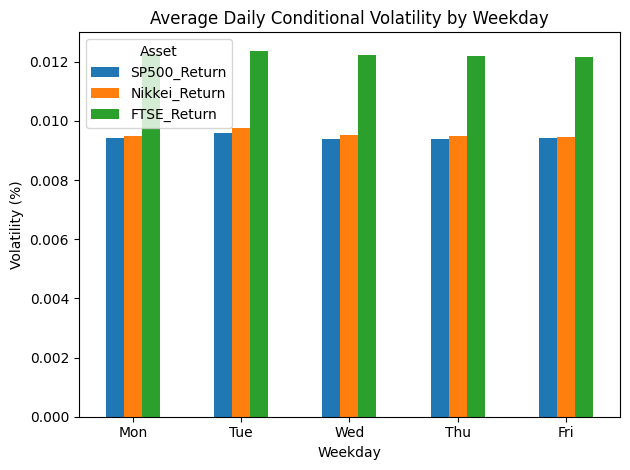

In [17]:
import matplotlib.pyplot as plt

avg_vol.plot(kind='bar')
plt.title('Average Daily Conditional Volatility by Weekday')
plt.ylabel('Volatility (%)')
plt.xlabel('Weekday')
plt.xticks(rotation=0)
plt.legend(title='Asset')
plt.tight_layout()
plt.show()